In [1]:
from astropy import constants as const
from astropy import units as u
from random import *
from scipy.stats import stats
from scipy.stats import norm
import scipy.integrate as integrate
from iminuit import Minuit
import pysynphot as S
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0   

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [2]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from regions import CircleSkyRegion

result_table = Simbad.query_object("lmc")
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg')
Circle = CircleSkyRegion(positions, 3.5 * u.deg)

In [3]:
df = pd.read_csv("Downloads\Cadences dobservation des nuages de Magellan/cadence_lmc_baseline_v1.csv", index_col=0)
df_2018a = pd.read_csv(r'D:\Projet de recherche\Stage\Baseline_LMCv1_Atmosphere.csv', index_col = 0)
df_LSST = pd.read_csv("D:\\Projet de recherche\Stage\lsst_throughput.csv", index_col=0)
df

,observationId,night,observationStartMJD,fiveSigmaDepth,filter,airmass,skyBrightness,seeingFwhmEff,fieldId,fieldRA,fieldDec
0,934,1,59854.385463,21.593537,y,1.240813,18.077206,1.283730,-1,81.586959,-66.516554
1,936,1,59854.386287,21.510902,y,1.289795,17.976992,1.313900,-1,82.257779,-69.379108
2,937,1,59854.386702,21.432884,y,1.346227,17.894386,1.348096,-1,83.188050,-72.229967
3,3045,4,59857.362131,22.986090,z,1.382600,19.148145,0.881487,-1,80.811831,-73.766990
4,3103,4,59857.386839,22.764444,z,1.237434,18.602993,0.854189,-1,82.308664,-66.330677
...,...,...,...,...,...,...,...,...,...,...,...
891,2060333,3447,63269.058829,23.475867,u,1.278024,22.608174,1.180799,-1,85.471063,-68.743581
892,2060366,3447,63269.074276,24.549840,g,1.394360,22.091690,1.028710,-1,83.849276,-74.182487
893,2060368,3447,63269.075104,24.647890,g,1.282391,22.138014,0.978318,-1,85.471063,-68.743581
894,2062061,3449,63271.110220,23.578175,u,1.275128,22.621678,1.079728,-1,84.404241,-65.817402


In [4]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

Text(0.5, 1.0, 'Distribution des $t_0$')

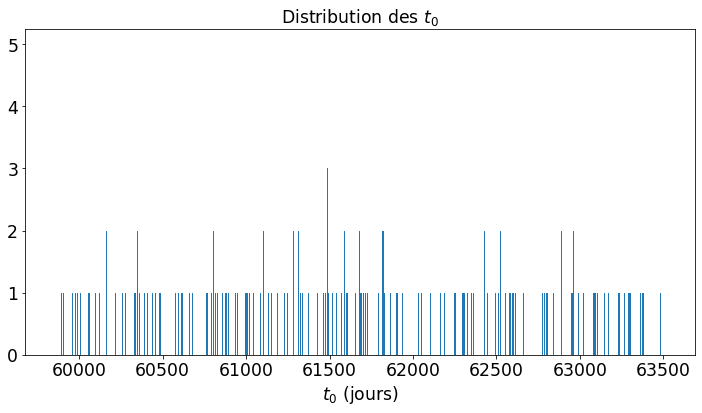

In [5]:
#Distribution t_0

NYEARS = 10
NDAYS = NYEARS*365.25
from scipy.stats import uniform
xmin = 0
xmax = NDAYS
N=1000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N)+ df["observationStartMJD"][0]

plt.hist(list_t0,bins=int(NDAYS));
plt.xlabel("$t_0$ (jours)")
plt.title("Distribution des $t_0$")

Text(0.5, 1.0, 'Densité de probabilité de $u_{min}$')

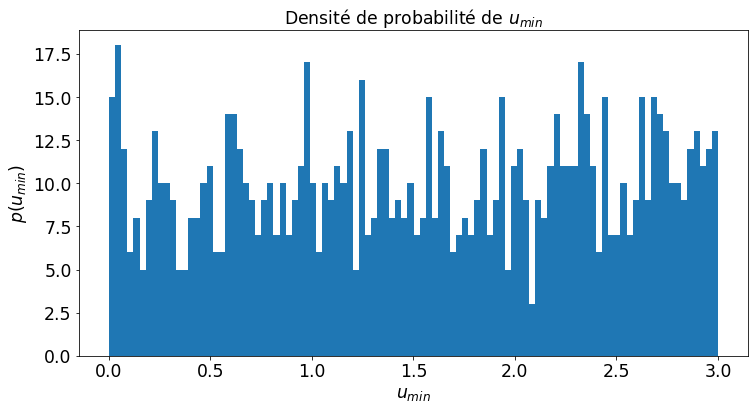

In [6]:
#Distribution u0

N = 1000
uminmin = 0
uminmax = 3
umin = uniform.rvs(uminmin,uminmax,N)

plt.hist(umin,bins=100)
plt.xlabel("$u_{min}$")
plt.ylabel("$p(u_{min})$")
plt.title("Densité de probabilité de $u_{min}$")

In [7]:
#relative angular source-lens separation

def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [8]:
#Amplitude

def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

In [9]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4)

In [10]:
#Linear fit

def linear(x, alpha, beta) : 
    return alpha*x + beta

In [11]:
Spec = S.Vega.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

In [12]:
D = Deff
Delta_T = EXPOSURE
F_ab = 3631*pow(10,-23)
Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)

In [13]:
F_b = []
N_pe = []
bp_atmo = []
all_obs = []
all_count = []
sigma_N = []
amp_err = []
all_bp = []

for i in range (len(df['observationStartMJD'])) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp = S.ArrayBandpass(df_LSST["wl"].values*10, df_2018a.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)


for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)

for bp in all_bp :
    
    obs = S.Observation(Spec, bp);
    all_obs.append(obs);
    
for obs in all_obs :
    
    all_count.append(obs.countrate()*EXPOSURE)

((y * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((i * Observation 90)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 91)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 92)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 93)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 94)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 95)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 96)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 97)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((g * Observation 182)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 183)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 184)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 185)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 186)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 187)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 188)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 189)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 272)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 273)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 274)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 275)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 276)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 277)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 278)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 279)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 350)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 351)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 352)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 353)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 354)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 355)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 356)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 357)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 441)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 442)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 443)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 444)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 445)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 446)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 447)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 448)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 534)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 535)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 536)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 537)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 538)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 539)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 540)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 541)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 627)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 628)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 629)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 630)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 631)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 632)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 633)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 634)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 713)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 714)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 715)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 716)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 717)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 718)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 719)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 720)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 801)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 802)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 803)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 804)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 805)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 806)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 807)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 808)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 891)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 892)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 893)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 894)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 895)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 896)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


In [14]:
for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))

In [15]:
for i in range (len(F_b)) :
    
    if (df['filter'].values[i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
    
    if (df['filter'].values[i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))


In [16]:
N = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))

In [17]:
chi2_10 = []
#chi2_linear = []
tE = 10
#Delta_chi2 = []
Ndof_10 = []
rejected_events_10= 0

for i in range (len(list_t0)) :
    
    t0 = list_t0[i]       
    u0 = umin[randrange(len(umin))]   #random u0 for every event 
    
    tmin = t0 - 5.*tE
    tmax = t0 + 5.*tE
    
    #Photometric error
    
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))

    
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    
    

#Restrictive cuts 
    
    if (len(x) - m.nfit > 1                                                # Ndof microlensing > 1                                           
        and len(x) - m_linear.nfit > 1                                                  # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0 ):                                         # Chi2 linear != 0
        #and m.fval/(len(x) - m.nfit) < 2                               # Goodness of fit chi2/Ndof < 2
        #and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 20 ) :  
        
        Ndof_10.append(len(x))
        
        chi2_10.append(m.fval)
         
        #chi2_linear.append(m_linear.fval/(len(x)))
        
        #Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((len(x)))))
        
    else :
        
        rejected_events_10 += 1

        
print(rejected_events_10)

658


In [18]:
chi2_20 = []
#chi2_linear = []
tE = 20
#Delta_chi2 = []
Ndof_20 = []
rejected_events_20 = 0

for i in range (len(list_t0)) :
    
    t0 = list_t0[i]       
    u0 = umin[randrange(len(umin))]   #random u0 for every event 
    
    tmin = t0 - 5.*tE
    tmax = t0 + 5.*tE
    
    
    
    #Photometric Error
    
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))

    
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    

#Restrictive cuts 
    
    if ((len(x) - m.nfit) > 1                                                # Ndof microlensing > 1                                           
        and (len(x) - m_linear.nfit) > 1                                                 # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0 ):                                          # Chi2 linear != 0
        #and m.fval/(len(x) - m.nfit) < 2                              # Goodness of fit chi2/Ndof < 2
        #and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 20 ) :  
        
        Ndof_20.append(len(x))
        
        chi2_20.append(m.fval)
         
        #chi2_linear.append(m_linear.fval/(len(x)))
        
        #Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((len(x)))))
        
    else :
        
        rejected_events_20 += 1

        
print(rejected_events_20)

373


In [19]:
chi2_30 = []
#chi2_linear = []
tE = 30
#Delta_chi2 = []
Ndof_30 = []
rejected_events_30 = 0

for i in range (len(list_t0)) :
    
    t0 = list_t0[i]       
    u0 = umin[randrange(len(umin))]   #random u0 for every event 
    
    tmin = t0 - 5.*tE
    tmax = t0 + 5.*tE
   
    
    #Photometric Error
    
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    
    

#Restrictive cuts 
    
    if ((len(x) - m.nfit) > 1                                               # Ndof microlensing > 1                                           
        and (len(x) - m_linear.nfit) > 1                                                  # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0 ):                                           # Chi2 linear != 0
        #and m.fval/(len(x) - m.nfit) < 2                                  # Goodness of fit chi2/Ndof < 2
        #and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 20 ) :  
        
        Ndof_30.append(len(x))
        
        chi2_30.append(m.fval)
         
        #chi2_linear.append(m_linear.fval/(len(x)))
        
        #Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((len(x)))))
        
    else :
        
        rejected_events_30 += 1

        
print(rejected_events_30)

115


In [20]:
chi2_50 = []
#chi2_linear = []
tE = 50
#Delta_chi2 = []
Ndof_50 = []
rejected_events_50 = 0

for i in range (len(list_t0)) :
    
    t0 = list_t0[i]       
    u0 = umin[randrange(len(umin))]   #random u0 for every event 
    
    tmin = t0 - 5.*tE
    tmax = t0 + 5.*tE
    
    
    
    
   
    
    #Photometric Error
    
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))
    
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    
    

#Restrictive cuts 
    
    if ((len(x) - m.nfit) > 1                                                # Ndof microlensing > 1                                           
        and (len(x) - m_linear.nfit) > 1                                                  # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0  ):                                        # Chi2 linear != 0
        #and m.fval/(len(x) - m.nfit) < 2                                 # Goodness of fit chi2/Ndof < 2
        #and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 20 ) :  
        
        Ndof_50.append(len(x))
        
        chi2_50.append(m.fval)
         
        #chi2_linear.append(m_linear.fval/(len(x)))
        
        #Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((len(x)))))
        
    else :
        
        rejected_events_50 += 1

        
print(rejected_events_50)

1


In [21]:
chi2_70 = []
#chi2_linear = []
tE = 70
#Delta_chi2 = []
Ndof_70 = []
rejected_events_70 = 0

for i in range (len(list_t0)) :
    
    t0 = list_t0[i]       
    u0 = umin[randrange(len(umin))]   #random u0 for every event 
    
    tmin = t0 - 5.*tE
    tmax = t0 + 5.*tE
    
    
    
    #Photometric Error
    
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))
    
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    
    

#Restrictive cuts 
    
    if ((len(x) - m.nfit) > 1                                               # Ndof microlensing > 1                                           
        and (len(x) - m_linear.nfit) > 1                                                  # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0  ):                                         # Chi2 linear != 0
        #and m.fval/(len(x) - m.nfit) < 2                                 # Goodness of fit chi2/Ndof < 2
        #and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 20 ) :  
        
        Ndof_70.append(len(x))
        
        chi2_70.append(m.fval)
         
        #chi2_linear.append(m_linear.fval/(len(x)))
        
        #Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((len(x)))))
        
    else :
        
        rejected_events_70 += 1

        
print(rejected_events_70)

0


In [22]:
chi2_100 = []
#chi2_linear = []
tE = 100
#Delta_chi2 = []
Ndof_100 = []
rejected_events_100 = 0

for i in range (len(list_t0)) :
    
    t0 = list_t0[i]       
    u0 = umin[randrange(len(umin))]   #random u0 for every event 
    
    tmin = t0 - 5.*tE
    tmax = t0 + 5.*tE
    
   
    #Photometric Error
    
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))

    
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    

#Restrictive cuts 
    
    if ((len(x) - m.nfit) > 1                                                # Ndof microlensing > 1                                           
        and (len(x) - m_linear.nfit) > 1                                                 # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0  ):                                         # Chi2 linear != 0
        #and m.fval/(len(x) - m.nfit) < 2                                 # Goodness of fit chi2/Ndof < 2
        #and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 20 ) :  
        
        Ndof_100.append(len(x) - m.nfit)
        
        chi2_100.append(m.fval)
         
        #chi2_linear.append(m_linear.fval/(len(x)))
        
        #Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((len(x)))))
        
    else :
        
        rejected_events_100 += 1

        
print(rejected_events_100)

0


In [23]:
chi2_150 = []
#chi2_linear = []
tE = 150
#Delta_chi2 = []
Ndof_150 = []
rejected_events_150 = 0

for i in range (len(list_t0)) :
    
    t0 = list_t0[i]       
    u0 = umin[randrange(len(umin))]   #random u0 for every event 
    
    tmin = t0 - 5.*tE
    tmax = t0 + 5.*tE
    
    

    
    
    #Photometric Error
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))

    
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    
    

#Restrictive cuts 
    
    if ((len(x) - m.nfit) > 1                                                # Ndof microlensing > 1                                           
        and (len(x) - m_linear.nfit) > 1                                                  # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0 ):                                          # Chi2 linear != 0
        #and m.fval/(len(x) - m.nfit) < 2                                 # Goodness of fit chi2/Ndof < 2
        #and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 20 ) :  
        
        Ndof_150.append(len(x))
        
        chi2_150.append(m.fval)
         
        #chi2_linear.append(m_linear.fval/(len(x)))
        
        #Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((len(x)))))
        
    else :
        
        rejected_events_150 += 1

        
print(rejected_events_150)

0


In [24]:
chi2_200 = []
#chi2_linear = []
tE = 200
#Delta_chi2 = []
Ndof_200 = []
rejected_events_200 = 0

for i in range (len(list_t0)) :
    
    t0 = list_t0[i]       
    u0 = umin[randrange(len(umin))]   #random u0 for every event 
    
    tmin = t0 - 5.*tE
    tmax = t0 + 5.*tE 
   
                                   # We consider every data point (no distinction between filters)   

    
    #Photometric Error
    
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))
    
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    

#Restrictive cuts 
    
    if ((len(x) - m.nfit) > 1                                                # Ndof microlensing > 1                                           
        and (len(x) - m_linear.nfit) > 1                                                  # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0 ):                                           # Chi2 linear != 0
        #and m.fval/(len(x) - m.nfit) < 2                                 # Goodness of fit chi2/Ndof < 2
        #and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 20 ) :  
        
        Ndof_200.append(len(x))
        
        chi2_200.append(m.fval)
         
        #chi2_linear.append(m_linear.fval/(len(x)))
        
        #Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((len(x)))))
        
    else :
        
        rejected_events_200 += 1

        
print(rejected_events_200)

0


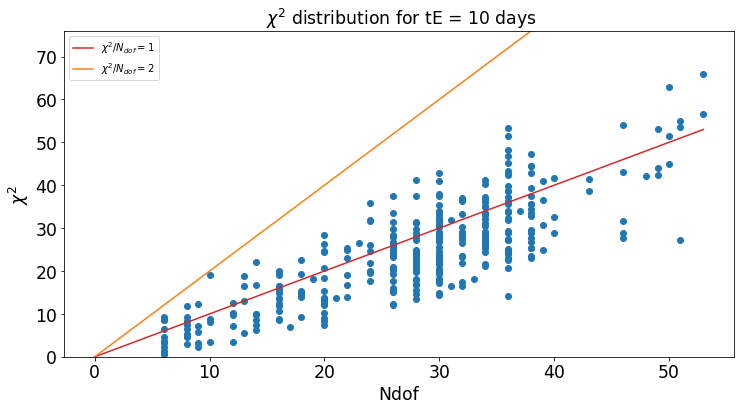

In [25]:
x_10 = np.linspace(0, max(Ndof_10), len(Ndof_10))
plt.scatter(Ndof_10, chi2_10)
plt.plot(x_10, linear(x_10, 1,0), label = "$\chi^2/N_{dof} = 1$", color = 'C3')
plt.plot(x_10, linear(x_10, 2,0), label = "$\chi^2/N_{dof} = 2$", color = 'C1')
plt.xlabel("Ndof")
plt.ylabel("$\chi^2$")
plt.ylim(0, max(chi2_10)+10)
plt.title(" $\chi^2$ distribution for tE = 10 days")
plt.legend()

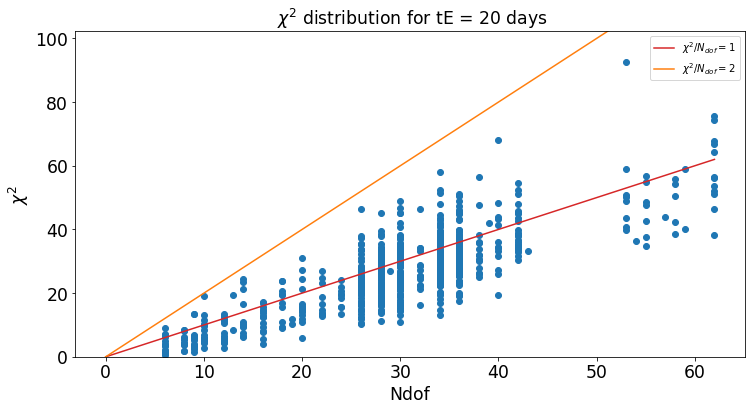

In [26]:
x_20 = np.linspace(0, max(Ndof_20), len(Ndof_20))
plt.scatter(Ndof_20, chi2_20)
plt.plot(x_20, linear(x_20, 1,0), label = "$\chi^2/N_{dof} = 1$", color = 'C3')
plt.plot(x_20, linear(x_20, 2,0), label = "$\chi^2/N_{dof} = 2$", color = 'C1')
plt.xlabel("Ndof")
plt.ylabel("$\chi^2$")
plt.ylim(0, max(chi2_20)+10)
plt.title(" $\chi^2$ distribution for tE = 20 days")
plt.legend()

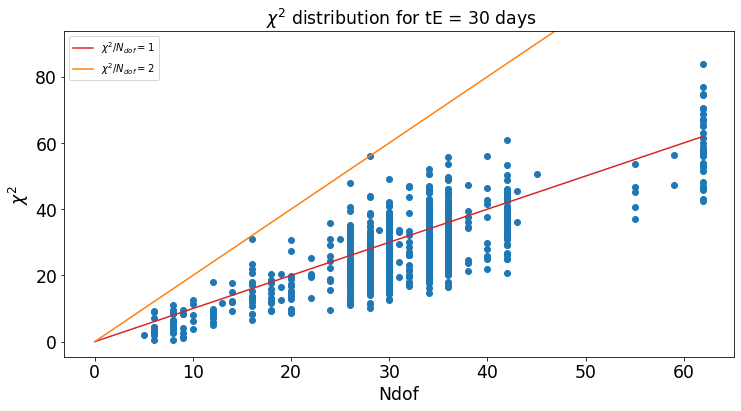

In [27]:
x_30 = np.linspace(0, max(Ndof_30), len(Ndof_30))
plt.scatter(Ndof_30, chi2_30)
plt.plot(x_30, linear(x_30, 1,0), label = "$\chi^2/N_{dof} = 1$", color = 'C3')
plt.plot(x_30, linear(x_30, 2,0), label = "$\chi^2/N_{dof} = 2$", color = 'C1')
plt.xlabel("Ndof")
plt.ylabel("$\chi^2$")
plt.ylim(min(chi2_30)-5, max(chi2_30)+10)
plt.title(" $\chi^2$ distribution for tE = 30 days")
plt.legend()

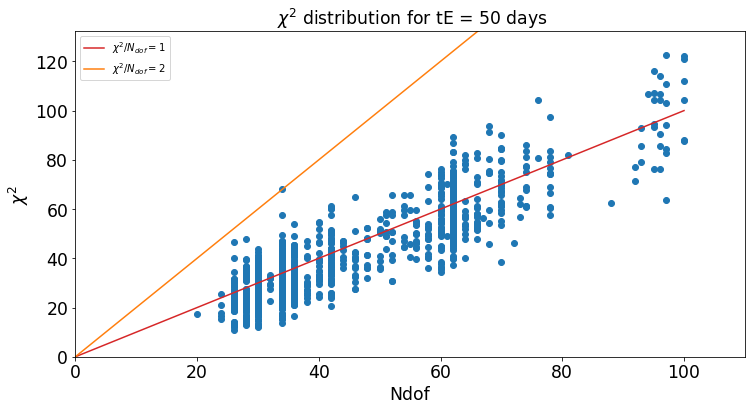

In [28]:
x_50 = np.linspace(0, max(Ndof_50), len(Ndof_50))
plt.scatter(Ndof_50, chi2_50)
plt.plot(x_50, linear(x_50, 1,0), label = "$\chi^2/N_{dof} = 1$", color = 'C3')
plt.plot(x_50, linear(x_50, 2,0), label = "$\chi^2/N_{dof} = 2$", color = 'C1')
plt.xlabel("Ndof")
plt.ylabel("$\chi^2$")
plt.xlim(0, max(Ndof_50)+10)
plt.ylim(0, max(chi2_50)+10)
plt.title(" $\chi^2$ distribution for tE = 50 days")
plt.legend()

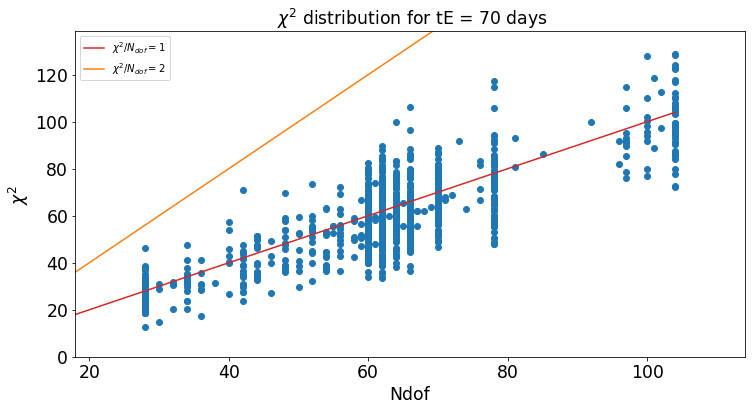

In [29]:
x_70 = np.linspace(0, max(Ndof_70), len(Ndof_70))
plt.scatter(Ndof_70, chi2_70)
plt.plot(x_70, linear(x_70, 1,0), label = "$\chi^2/N_{dof} = 1$", color = 'C3')
plt.plot(x_70, linear(x_70, 2,0), label = "$\chi^2/N_{dof} = 2$", color = 'C1')
plt.xlabel("Ndof")
plt.ylabel("$\chi^2$")
plt.xlim(min(Ndof_70)-10, max(Ndof_70)+10)
plt.ylim(0, max(chi2_70)+10)
plt.title(" $\chi^2$ distribution for tE = 70 days")
plt.legend()

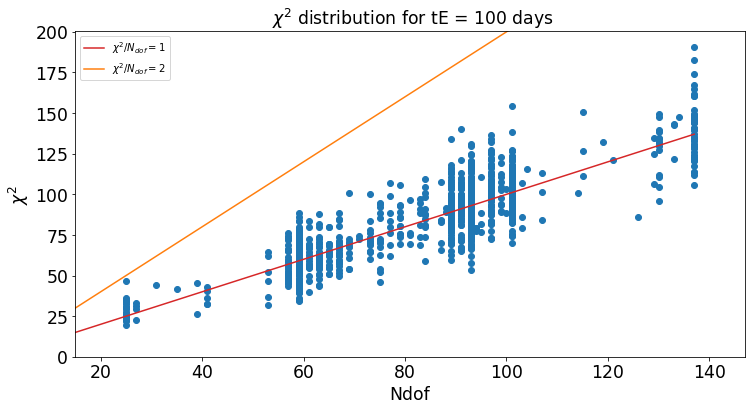

In [30]:
x_100 = np.linspace(0, max(Ndof_100), len(Ndof_100))
plt.scatter(Ndof_100, chi2_100)
plt.plot(x_100, linear(x_100, 1,0), label = "$\chi^2/N_{dof} = 1$", color = 'C3')
plt.plot(x_100, linear(x_100, 2,0), label = "$\chi^2/N_{dof} = 2$", color = 'C1')
plt.xlabel("Ndof")
plt.ylabel("$\chi^2$")
plt.xlim(min(Ndof_100)-10, max(Ndof_100)+10)
plt.ylim(0, max(chi2_100)+10)
plt.title(" $\chi^2$ distribution for tE = 100 days")
plt.legend()

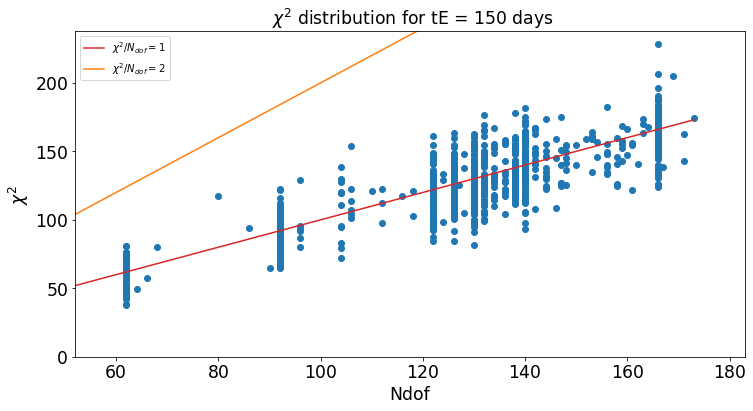

In [31]:
x_150 = np.linspace(0, max(Ndof_150), len(Ndof_150))
plt.scatter(Ndof_150, chi2_150)
plt.plot(x_150, linear(x_150, 1,0), label = "$\chi^2/N_{dof} = 1$", color = 'C3')
plt.plot(x_150, linear(x_150, 2,0), label = "$\chi^2/N_{dof} = 2$", color = 'C1')
plt.xlabel("Ndof")
plt.ylabel("$\chi^2$")
plt.xlim(min(Ndof_150)-10, max(Ndof_150)+10)
plt.ylim(0, max(chi2_150)+10)
plt.title(" $\chi^2$ distribution for tE = 150 days")
plt.legend()

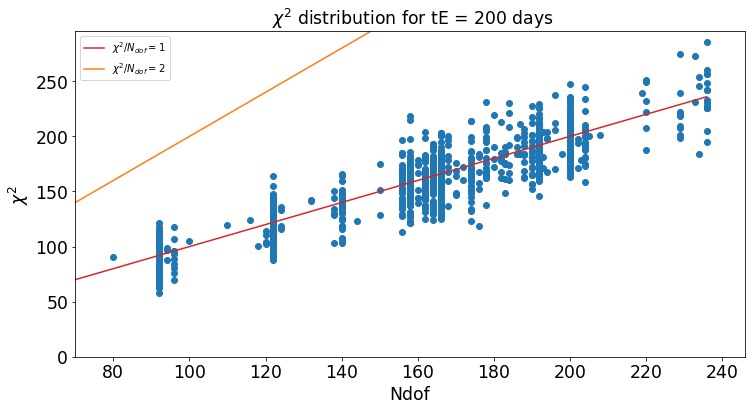

In [32]:
x_200 = np.linspace(0, max(Ndof_200), len(Ndof_200))
plt.scatter(Ndof_200, chi2_200)
plt.plot(x_200, linear(x_200, 1,0), label = "$\chi^2/N_{dof} = 1$", color = 'C3')
plt.plot(x_200, linear(x_200, 2,0), label = "$\chi^2/N_{dof} = 2$", color = 'C1')
plt.xlabel("Ndof")
plt.ylabel("$\chi^2$")
plt.xlim(min(Ndof_200)-10, max(Ndof_200)+10)
plt.ylim(0, max(chi2_200)+10)
plt.title(" $\chi^2$ distribution for tE = 200 days")
plt.legend()

Text(0.5, 1.0, 'tE = 50 days')

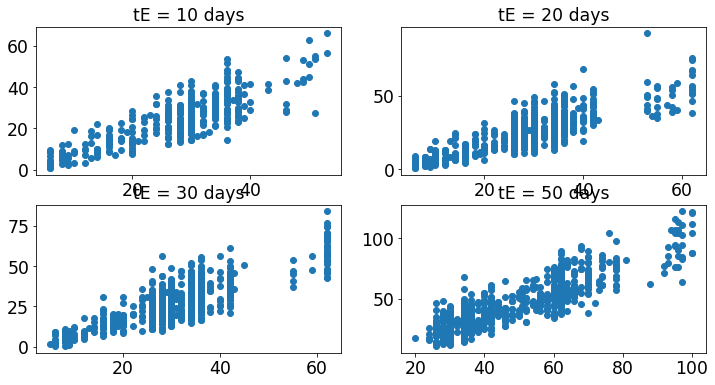

In [33]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(Ndof_10, chi2_10)
axs[0, 0].set_title('tE = 10 days')
axs[0, 1].scatter(Ndof_20, chi2_20)
axs[0, 1].set_title('tE = 20 days')
axs[1, 0].scatter(Ndof_30, chi2_30)
axs[1, 0].set_title('tE = 30 days')
axs[1, 1].scatter(Ndof_50, chi2_50)
axs[1, 1].set_title('tE = 50 days')

Text(0, 0.5, 'chi2')

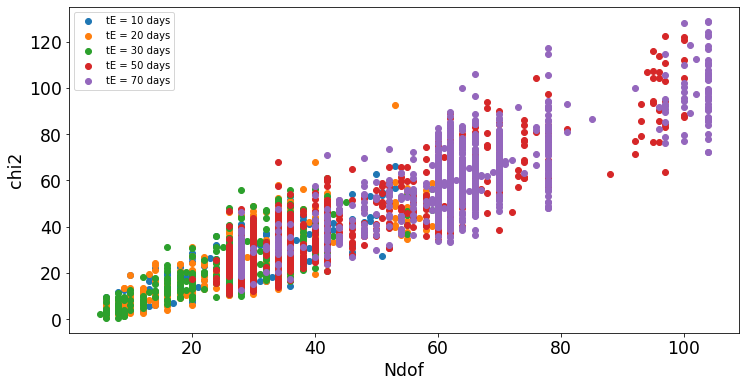

In [34]:
plt.scatter(Ndof_10, chi2_10, label = "tE = 10 days")
plt.scatter(Ndof_20, chi2_20, label = "tE = 20 days")
plt.scatter(Ndof_30, chi2_30, label = "tE = 30 days")
plt.scatter(Ndof_50, chi2_50, label = "tE = 50 days")
plt.scatter(Ndof_70, chi2_70, label = "tE = 70 days")
plt.legend()
plt.xlabel("Ndof")
plt.ylabel("chi2")

Text(0, 0.5, 'Detection Efficiency')

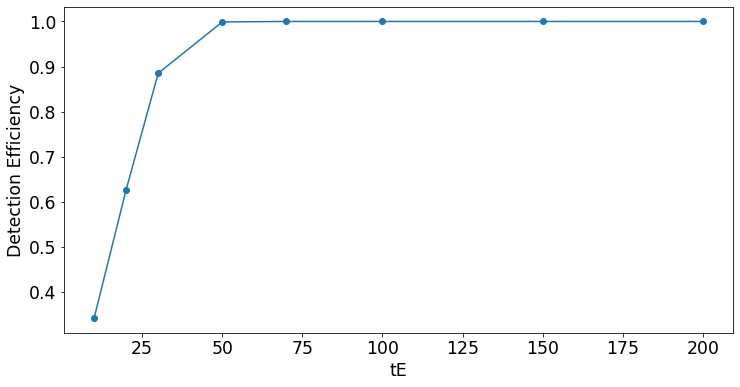

In [35]:
temp = [(1000-rejected_events_10)/1000, (1000-rejected_events_20)/1000, (1000-rejected_events_30)/1000, (1000-rejected_events_50)/1000, (1000-rejected_events_70)/1000, (1000-rejected_events_100)/1000, (1000-rejected_events_150)/1000, (1000-rejected_events_200)/1000]
t = (10,20,30,50,70,100,150,200)

plt.plot(t, temp)
plt.scatter(t, temp)
plt.xlabel("tE")
plt.ylabel("Detection Efficiency")